# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url)
btc_content = btc_data.content
btc_info = btc_data.json()

# print(json.dumps(btc_info, indent=4))

btc_price = btc_info['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_data = requests.get(eth_url)
eth_content = eth_data.content
eth_info = eth_data.json()

# print(json.dumps(eth_info, indent=4))

eth_price = eth_info['data']['1027']['quotes']['USD']['price']


# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $49227.60
The current value of your 5.3 ETH is $15481.03


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)


api = REST(key_id = alpaca_api_key, secret_key = alpaca_secret_key)

In [8]:
# Format current date as ISO format

start_date = pd.Timestamp("2022-03-14", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-03-14", tz="America/New_York").isoformat()


# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)

ticker_data_agg =  api.get_bars("AGG", tradeapi.TimeFrame(1, tradeapi.TimeFrameUnit.Day), start = start_date, end = end_date).df
ticker_data_spy =  api.get_bars("SPY", tradeapi.TimeFrame(1, tradeapi.TimeFrameUnit.Day), start = start_date, end = end_date).df



In [9]:
# Pick AGG and SPY close prices

agg_close_price = ticker_data_agg['close'].values
spy_close_price = ticker_data_spy['close'].values


# # Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $[107.36]
Current SPY closing price: $[417]


In [10]:
# Compute the current value of shares
my_agg_value = float(my_agg * agg_close_price)
my_spy_value = float(my_spy * spy_close_price)

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value}")

The current value of your 50 SPY shares is $20850.0
The current value of your 200 AGG shares is $21472.0


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_value = my_btc_value + my_eth_value
shares_value = my_agg_value + my_spy_value


# # Create savings DataFrame
type_of_investment = ['crypto', 'shares']
investment_values = {'amounts': [crypto_value, shares_value]}

df_savings = pd.DataFrame(investment_values, index=type_of_investment)

# # Display savings DataFrame
display(df_savings)

,amounts
crypto,64708.635
shares,42322.000


<AxesSubplot:title={'center':'Value of Securities Composition'}, ylabel='amounts'>

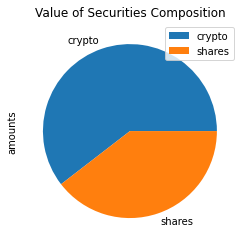

In [12]:
# Plot savings pie chart

df_savings.plot.pie( y="amounts", title="Value of Securities Composition")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amounts'][0] + df_savings['amounts'][1]

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations for having enough money in this fund.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching this financial goal.")
else:
    dollar_goal = emergency_fund - total_savings
    print(dollar_goal)
        

Congratulations for having enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [52]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)

df_agg = api.get_bars("AGG", tradeapi.TimeFrame(1, tradeapi.TimeFrameUnit.Day), start = start_date, end = end_date).df
df_spy = api.get_bars("SPY", tradeapi.TimeFrame(1, tradeapi.TimeFrameUnit.Day), start = start_date, end = end_date).df

df_agg = df_agg.drop(columns=["trade_count", 'vwap'])
df_spy = df_spy.drop(columns=["trade_count", 'vwap'])


In [31]:
df_stock_data = pd.concat([df_agg, df_spy],axis=1, join='outer', keys=("AGG", "SPY"))

df_stock_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                              SPY                                       
                             open    high     low     close     volume  
timestamp                                                               
2016-05-02 04:00:00+00:00  206.90  208.18  206.41  207.9700   61908515  
2016-05-03 04:00:00+00:00  206.53  206.80  205.28  206.1592  106422142  
2016-05-04 04:00:00+00:00  204.96  205.85  204.42  205.0100   92199810  
2016-05-05 04:00:00+00:00  205.57  205.98  204.47  204.9700   67597222  
2016-05-06 04:00:00+00:00  204.08  205.77  203.88  205.7200   89131004

In [32]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_Stock = MCSimulation(
    portfolio_data= df_stock_data,
    weights = [.40, .60],
    num_simulation= 500,
    num_trading_days=252 * 30
)

In [33]:
# Printing the simulation input data
MC_Stock.portfolio_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                           SPY                            \
                          daily_return    open    high     low     close   
timestamp                                                                  
2016-05-02 04:00:00+00:00          NaN  206.90  208.18  206.41  207.9700   
2016-05-03 04:00:00+00:00     0.001853  206.53  206.80  205.28  206.1592   
2016-05-04 04:00:00+00:00     0.000451  204.96  205.85  204.42  205.0100   
2016-05-05 04:00:00+00:00     0.002526  205.57  205.98  204.47  204.9700   
2016-05-06 04:00:00+00:00    -0.001530  204.08  205.77  203.88  205.7200   

                                                   
                              volume daily_return  
timestamp                                          
2016-05-02 04:00:00+00:00   61908515          NaN  
2016-05-03 04:00:00+00:00  106422142    -0.008707  
2016-05-04 04:00:00+00:00   92199810    -0.005574  
2016-05-05 04:00:00+00:00   67597222    -0.000195  
2016-05-06 04:00:00+00:00   89131004     0.003659

In [34]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_Stock.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


D:\Desktop\NWBootcamp\Homework\Homework-API\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996563,0.990509,1.001591,1.006427,0.999142,0.998812,0.995378,0.999860,1.007944,1.002028,...,1.005244,1.000977,0.993296,1.000864,0.997108,1.000664,1.011758,1.000261,1.002859,0.987573
2,0.998918,0.983429,0.995572,1.012564,1.009473,1.006209,1.007912,0.998178,1.001320,1.013658,...,1.005185,0.991882,0.990102,1.012141,0.995518,0.991783,1.007403,1.001038,1.001691,0.991530
3,0.996171,0.980357,1.001641,1.008344,0.999933,1.012841,1.010916,0.999441,0.993009,1.015111,...,1.011631,0.996911,0.987782,1.013334,0.990927,0.989192,1.010724,1.002445,1.003981,0.979152
4,1.004249,0.988929,1.001069,1.015734,1.007371,1.010431,1.008813,0.991388,0.994999,1.017480,...,1.015621,0.996667,0.990461,1.008578,0.990539,0.988553,1.014373,1.007443,0.992606,0.976411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,10.151227,12.878105,25.197390,5.825513,24.394799,15.838270,20.015437,20.725146,11.037670,23.919179,...,23.212359,27.847700,25.893540,11.408861,12.784089,18.602933,32.648380,33.150248,7.462860,16.485262
7557,10.057485,12.928225,25.435966,5.893846,24.212817,15.973160,20.183286,20.596721,11.029256,23.827467,...,23.383395,27.475616,26.151188,11.486813,12.855464,18.777679,32.543404,33.204514,7.482020,16.456978
7558,10.080753,12.954730,25.182188,5.936760,24.208280,15.924003,20.089340,20.637462,11.007116,23.678340,...,23.436857,27.597507,26.499903,11.323840,12.836804,19.031120,32.197272,32.988867,7.464322,16.410161
7559,10.052898,12.944424,25.043854,5.899598,24.267207,16.132518,20.126872,20.642157,10.960459,23.625049,...,23.643636,27.584908,26.282410,11.157457,12.780932,18.993711,32.218113,32.664005,7.496239,16.237852


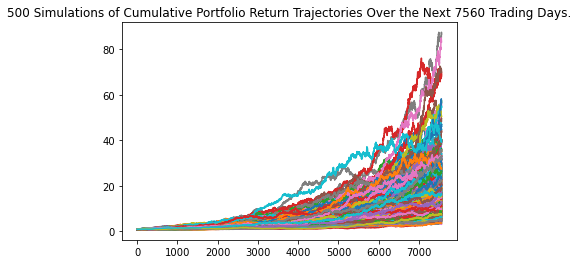

In [35]:
# Plot simulation outcomes
stock_line_plot = MC_Stock.plot_simulation()

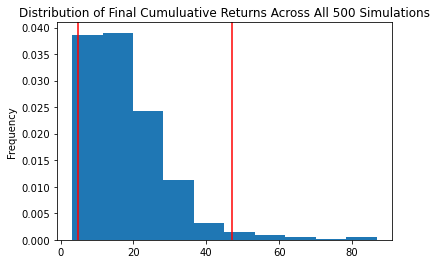

In [36]:
# Plot probability distribution and confidence intervals
stock_dist_plot = MC_Stock.plot_distribution()

### Retirement Analysis

In [37]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_tbl = MC_Stock.summarize_cumulative_return()

# Print summary statistics
print(stock_tbl)

count           500.000000
mean             18.116329
std              11.582863
min               3.170389
25%              10.028712
50%              15.061546
75%              23.985042
max              86.716531
95% CI Lower      4.873263
95% CI Upper     47.020566
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [38]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(stock_tbl[8] * initial_investment, 2)
ci_upper = round(stock_tbl[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $97465.26 and $940411.31


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [39]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(stock_tbl[8] * initial_investment, 2)
ci_upper = round(stock_tbl[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $146197.89 and $1410616.97


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [40]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_Stock_5yr = MCSimulation(
    portfolio_data= df_stock_data,
    weights = [.40, .60],
    num_simulation= 500,
    num_trading_days=252 * 5
)

In [41]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_Stock_5yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


D:\Desktop\NWBootcamp\Homework\Homework-API\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995480,0.997186,0.992307,0.993499,0.995325,0.999632,1.001868,0.997883,0.996736,0.995492,...,0.984849,1.004140,0.990597,1.001467,0.995780,1.009408,1.000784,1.000665,0.994219,1.003928
2,0.995410,0.999567,0.971970,1.003610,1.007532,0.995410,0.995810,1.000402,0.993335,0.993648,...,0.996027,1.006475,0.993533,0.996304,0.990890,1.017665,0.999614,0.999438,1.006478,1.011109
3,0.992751,1.001567,0.985287,1.002844,1.007539,1.006668,0.995151,1.011773,1.003845,0.996771,...,0.996183,1.006684,0.994073,0.992871,0.992342,1.021843,1.000197,0.993549,1.016867,1.012084
4,0.976889,1.003198,0.986057,1.007476,1.008059,1.004036,0.995381,1.007865,1.006541,0.995614,...,0.996058,1.017567,0.991324,0.984728,0.994846,1.030057,1.001757,1.005222,1.024860,1.015846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.062713,1.608834,1.702754,1.163511,1.316071,1.381782,1.767864,1.374484,1.235862,1.626304,...,1.897114,1.494014,1.507041,1.110988,1.363542,1.670937,1.504595,1.582506,1.807043,2.028608
1257,1.060971,1.608690,1.706125,1.167031,1.322442,1.377981,1.783083,1.370997,1.238420,1.619404,...,1.880440,1.509434,1.496075,1.113684,1.372325,1.668339,1.519416,1.568468,1.791514,2.019940
1258,1.066154,1.610883,1.712810,1.161035,1.314291,1.369987,1.802835,1.358466,1.243258,1.607833,...,1.883208,1.496053,1.501714,1.110651,1.360299,1.662723,1.515777,1.553161,1.788903,2.013698
1259,1.071482,1.602898,1.740444,1.165224,1.323117,1.365763,1.797300,1.328174,1.245061,1.592198,...,1.902518,1.493527,1.511721,1.115252,1.351212,1.666552,1.522231,1.544640,1.784261,2.027162


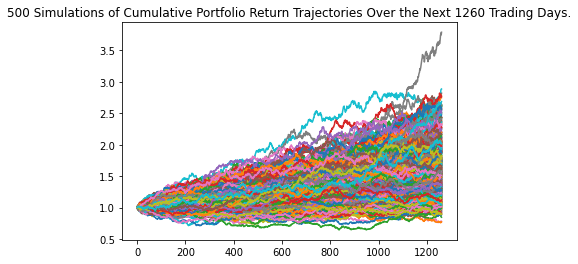

In [42]:
# Plot simulation outcomes
stock_5yr_line_plot = MC_Stock_5yr.plot_simulation()

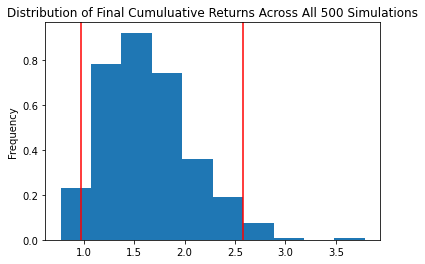

In [43]:
# Plot probability distribution and confidence intervals
stock_5yr_dist_plot = MC_Stock_5yr.plot_distribution()

In [44]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_5yr_tbl = MC_Stock_5yr.summarize_cumulative_return()

# Print summary statistics
print(stock_5yr_tbl)

count           500.000000
mean              1.628517
std               0.424672
min               0.769678
25%               1.317526
50%               1.572197
75%               1.891722
max               3.788425
95% CI Lower      0.974600
95% CI Upper      2.583748
Name: 1260, dtype: float64


In [45]:
# Set initial investment
new_initial_investment_5yr = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(stock_5yr_tbl[8] * new_initial_investment_5yr, 2)
ci_upper_five = round(stock_5yr_tbl[9] * new_initial_investment_5yr, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${new_initial_investment_5yr} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 5 years will end within in the range of $97460.05 and $258374.8


### Ten Years Retirement Option

In [46]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_Stock_10yr = MCSimulation(
    portfolio_data= df_stock_data,
    weights = [.40, .60],
    num_simulation= 500,
    num_trading_days=252 * 10
)

In [47]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_Stock_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


D:\Desktop\NWBootcamp\Homework\Homework-API\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003730,1.003364,1.007013,1.003979,0.991919,0.989703,1.019608,0.995919,0.999547,1.004272,...,1.005054,0.981107,1.000603,0.985219,1.004173,1.010867,0.994171,0.995429,0.998299,1.012500
2,1.000300,0.993223,1.010269,1.005750,0.987880,0.995596,1.022657,1.001894,0.998933,1.013197,...,1.001204,0.985992,0.991205,0.987383,1.009755,1.008710,1.000365,0.992341,0.990550,1.007308
3,0.997764,0.993152,1.018152,0.997672,0.997299,0.993037,1.017913,1.003683,0.988578,1.009344,...,0.987305,1.002604,0.999257,0.986523,1.013639,1.007187,1.008599,0.989377,0.997673,1.011782
4,0.998353,0.992708,1.012546,0.998233,0.989461,0.994845,0.998924,1.001154,0.986516,1.004526,...,0.993137,1.007133,0.991208,0.989725,1.008858,1.006097,1.002266,1.001073,1.001544,0.992563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.857544,2.783485,1.966641,2.462476,2.658262,5.320598,2.218857,2.504095,3.137684,2.235124,...,1.878241,3.261063,1.718705,3.095996,2.311374,2.252902,1.957394,1.503062,1.976166,2.512109
2517,2.852582,2.766575,1.988787,2.475623,2.662949,5.299268,2.217484,2.483629,3.123830,2.252608,...,1.871882,3.281220,1.722140,3.054478,2.321250,2.258307,1.967095,1.509857,1.978846,2.544028
2518,2.867732,2.724393,1.990188,2.472342,2.662853,5.345958,2.214792,2.468808,3.134493,2.227660,...,1.892877,3.293942,1.704078,3.043428,2.304880,2.264926,2.009831,1.492458,1.977953,2.539655
2519,2.838347,2.734788,2.003602,2.451289,2.674312,5.317577,2.216985,2.481525,3.135257,2.230734,...,1.897213,3.293574,1.701425,3.047895,2.305480,2.262583,1.992626,1.500279,1.972986,2.530872


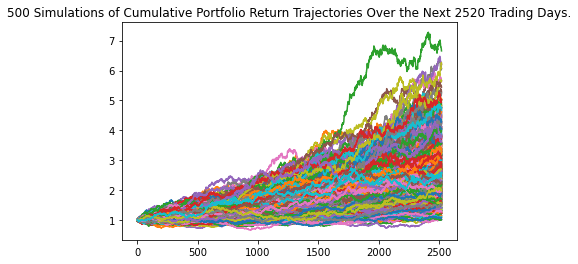

In [48]:
# Plot simulation outcome
stock_10yr_line_plot = MC_Stock_10yr.plot_simulation()

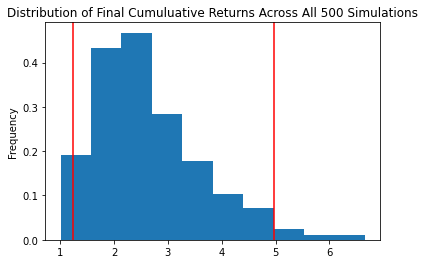

In [49]:
# Plot probability distribution and confidence intervals
stock_10yr_dist_plot = MC_Stock_10yr.plot_distribution()

In [50]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_10yr_tbl = MC_Stock_10yr.summarize_cumulative_return()

# Print summary statistics
print(stock_10yr_tbl)

count           500.000000
mean              2.637070
std               0.984551
min               1.007982
25%               1.950143
50%               2.455641
75%               3.149929
max               6.657116
95% CI Lower      1.234515
95% CI Upper      4.971280
Name: 2520, dtype: float64


In [51]:
# Set initial investment
new_initial_investment_10yr = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(stock_10yr_tbl[8] * new_initial_investment_10yr, 2)
ci_upper_ten = round(stock_10yr_tbl[9] * new_initial_investment_10yr, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${new_initial_investment_10yr} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 10 years will end within in the range of $123451.51 and $497128.04
